In [5]:
!pip install shap

In [30]:
!pip install 'tensorflow==1.14.0'
!pip install keras==2.3.1

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [28]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from modeling import FoldSet, GridSearch_ML, MLTest, RF_importances # ML
from rnn_modeling import Make_DataSet, Search_RNN, Model_RNN # RNN
from visualization import Result_pred, Monthly_plot, Hourly_plot, TimeBar, Correlation
from visualization import Plot_Result, Result_RNN

# Load data

In [10]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Train_Mp.csv')
print(df.shape)
df

(36610, 13)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Cloudy,Visibility,Time,Date,Area,Photovoltaics,Month
0,2.6,6.0,290.0,91.0,1019.6,0.0,10.0,1300.0,9,2013-01-01,전남 목포시,20.16,1
1,4.2,5.8,250.0,82.0,1019.9,0.7,7.0,1300.0,10,2013-01-01,전남 목포시,106.80,1
2,3.8,7.1,320.0,80.0,1020.5,0.7,9.0,1300.0,11,2013-01-01,전남 목포시,469.56,1
3,4.9,2.8,290.0,73.0,1020.1,0.7,7.0,1300.0,12,2013-01-01,전남 목포시,504.24,1
4,5.2,6.7,320.0,66.0,1019.7,0.8,6.0,1100.0,13,2013-01-01,전남 목포시,745.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36605,-0.2,5.9,360.0,79.0,1031.4,0.2,9.0,1206.0,14,2021-12-31,전남 목포시,312.00,12
36606,-0.7,5.0,360.0,83.0,1031.4,0.0,10.0,1040.0,15,2021-12-31,전남 목포시,163.80,12
36607,-0.6,5.1,360.0,83.0,1031.5,0.0,10.0,1057.0,16,2021-12-31,전남 목포시,103.44,12
36608,0.6,6.9,360.0,69.0,1031.1,0.0,9.0,2000.0,17,2021-12-31,전남 목포시,45.36,12


In [11]:
df['Date'].str[:4].unique()

array(['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021'], dtype=object)

In [12]:
df['Area'].unique()

array(['전남 목포시'], dtype=object)

# Create Deviation Variable

In [13]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time','Year']]
cols

['Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Sunshine',
 'Cloudy',
 'Visibility',
 'Photovoltaics']

In [14]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)



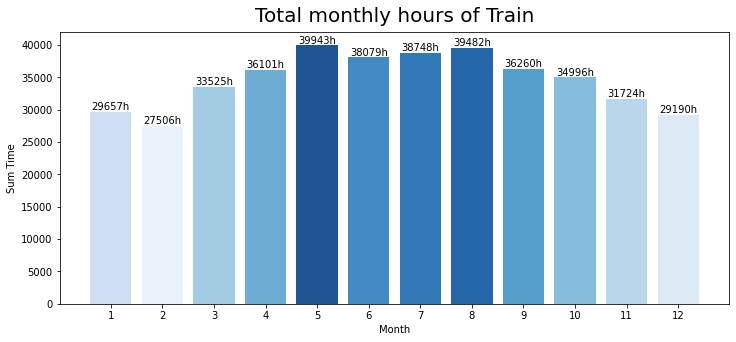

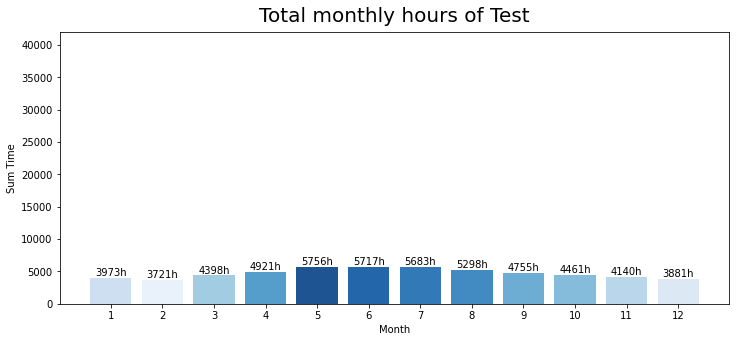

In [15]:
TimeBar(df.loc[:32287-1], 'Train', 42000)
TimeBar(df.loc[32287:], 'Test', 42000)

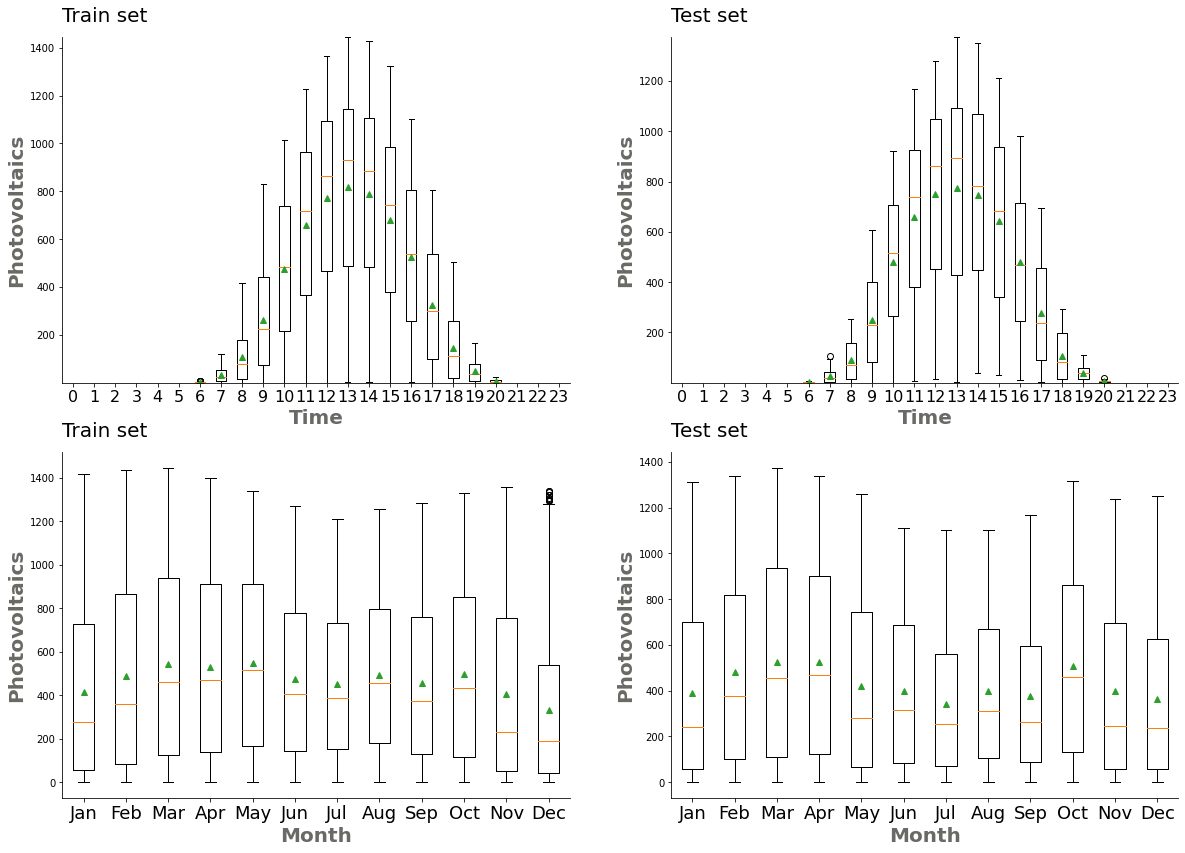

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
Hourly_plot(df.loc[:32287-1], 'Photovoltaics', ax1, 'Train set')
Monthly_plot(df.loc[:32287-1], 'Photovoltaics', ax3, 'Train set')
Hourly_plot(df.loc[32287:], 'Photovoltaics', ax2, 'Test set')
Monthly_plot(df.loc[32287:], 'Photovoltaics', ax4, 'Test set')

In [ ]:
train_Mp = pd.concat([x_train, y_train], axis=1)
train_Mp

,dev_Temperature,dev_Wind velocity,dev_Wind direction,dev_Humidity,dev_Sea-level pressure,dev_Sunshine,dev_Cloudy,dev_Visibility,dev_Photovoltaics
0,2.061187,3.538813,148.584475,12.223744,-6.769406,-0.298174,4.515982,-13.689498,-25.226849
1,2.322477,2.841743,103.944954,7.486239,-6.639450,0.147248,1.894495,-32.559633,-138.406789
2,0.855455,3.554545,118.772727,9.463636,-5.927273,0.068182,4.086364,-92.918182,-40.891091
3,1.136406,-1.170046,63.824885,5.529954,-5.753456,0.021198,2.354839,-131.612903,-225.575115
4,0.643056,2.356019,76.805556,1.236111,-5.260185,0.109259,1.282407,-386.819444,-65.591111
...,...,...,...,...,...,...,...,...,...
32282,-7.918357,-3.842995,-65.507246,7.888889,1.023671,-0.308213,2.396135,387.942029,-402.318261
32283,-7.148058,2.729126,58.398058,22.635922,0.727184,-0.366019,3.305825,-1090.140777,-352.078835
32284,-6.998095,2.055714,77.619048,22.338095,0.784286,-0.341429,2.280952,383.938095,-36.441143
32285,-5.151659,2.723223,78.483412,5.085308,0.659242,-0.290995,2.246445,403.421801,2.674692


In [ ]:
train_Mp.columns

Index(['dev_Temperature', 'dev_Wind velocity', 'dev_Wind direction',
       'dev_Humidity', 'dev_Sea-level pressure', 'dev_Sunshine', 'dev_Cloudy',
       'dev_Visibility', 'dev_Photovoltaics'],
      dtype='object')

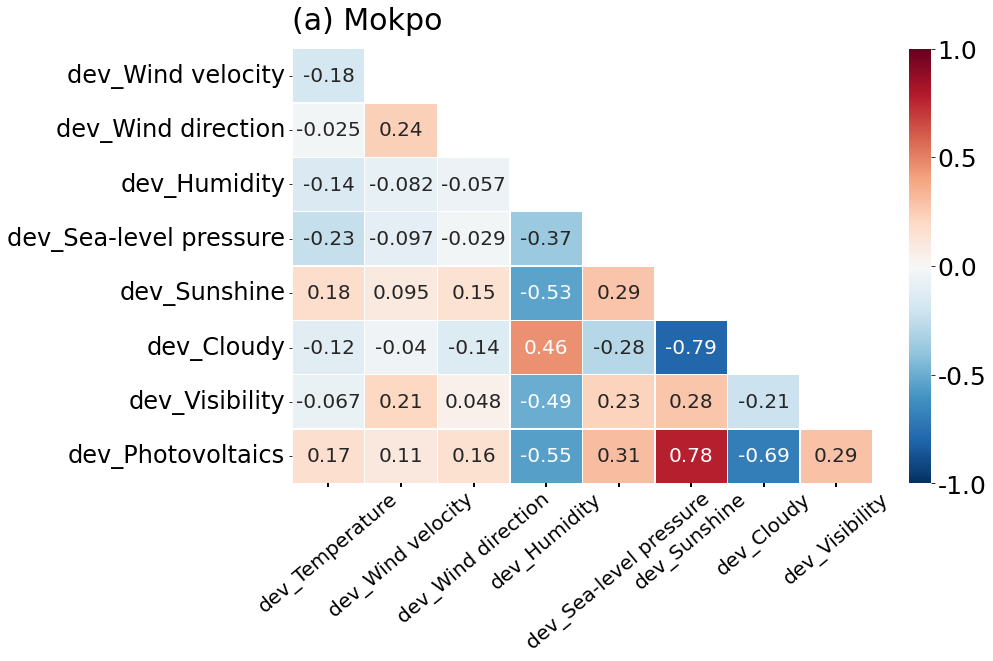

In [ ]:
fig, ax1 =  plt.subplots(figsize=(15, 12))
ax1.set_title('(a) Mokpo', loc='left', x=0, y=1.03, fontsize=30)
c = Correlation(train_Mp, train_Mp.columns, ax1)
cbar = fig.get_children()[-1]
cbar.set_yticklabels([-1.00, -0.50, 0.00, 0.50, 1.00], fontsize=25)
fig.savefig('Mp_corr.png',  bbox_inches='tight', pad_inches=0, dpi=500)

# Fine-tuning the model

In [16]:
params = {}

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)
GridSearch_ML(df, cols, params, dev=True)
GridSearch_ML(df, cols, params, dev=False)

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'RNN', dev = True)
params = Search_RNN(df, params, 'LSTM', dev=True)
params = Search_RNN(x_train, y_train, params, 'GRU', dev=True)

testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'RNN')
params = Search_RNN(x_train, y_train, params, 'LSTM')
params = Search_RNN(x_train, y_train, params, 'GRU')

In [18]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 4000, 'solver': 'adam'}
dev_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 35, 'objective': 'regression'}
ori_MLP {'activation': 'logistic', 'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}
ori_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
dev_LSTM {'optimizer': 'Adam', 'epochs': 30, 'dropout': 0.4, 'dense_nparams': 128, 'batch_size': 64, 'activation': 'relu'}
dev_GRU {'optimizer': 'Adam', 'epochs': 25, 'dropout': 0.2, 'dense_nparams': 128, 'batch_size': 12, 'activation': 'relu'}
ori_LSTM {'optimizer': 'Adamax', 'epochs': 35, 'dropout': 0.2, 'dense_nparams': 128, 'batch_size': 12, 'activation': 'tanh'}
ori_GRU {'optimizer': 'Adamax', 'epochs': 30, 'dropout': 0, 'dense_nparams': 128, 'batch_size': 2, 'activatio

# Feature Importances

In [ ]:
importances = RF_importances(df, dev=False)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

explained varaiance : 0.6025185492852436
 MAPE : 10.338610585756449


In [ ]:
dev_importances = RF_importances(df, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

explained varaiance : 0.8252933956513555
 MAPE : 4.227290809611111


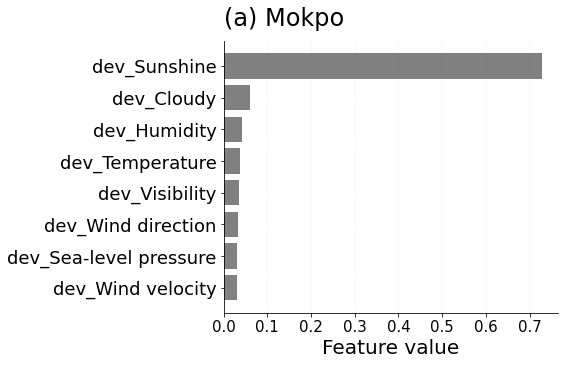

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), ncols=1, nrows=1)
plt.title('(a) Mokpo', loc='left', pad=15, fontsize=24)
pal = sns.color_palette('BuPu', n_colors=len(dev_importances.keys()))
ax.barh(y=range(0, len(dev_importances.keys())), width=dev_importances.values(), color='grey')
ax.set_yticklabels(labels=list(dev_importances.keys()), fontsize=18)
ax.set_yticks(range(0, len(dev_importances.keys())))
ax.set_xticklabels(np.round(np.arange(0, 1.0, 0.1),1), fontsize=15)
ax.set_xlabel('Feature value', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='x', color='#696965', linewidth=0.1, linestyle=':')
fig.savefig('Mp_features.png', bbox_inches='tight', dpi=500)
plt.show()

# Model Learning & SHAP

In [19]:
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False, color='grey')
  plt.xlabel('mean(|SHAP value|)', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()

  shap.summary_plot(shap_values, x_train, plot_size=0.3, show=False)
  plt.xlabel('SHAP value', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()

In [20]:
def Shap_RNN(shap_model, train_X, model, cols):
  tf.compat.v1.keras.backend.get_session(op_input_list=())
  
  explainer = shap.GradientExplainer(model = shap_model, data = train_X)
  shap_values = explainer.shap_values(train_X)

  shap_values_2D = shap_values[0].reshape(-1,8)
  X_train_2D = train_X.reshape(-1,8)

  shap.summary_plot(shap_values_2D, X_train_2D, cols, plot_size=0.3, plot_type='bar', show=False, color='grey')
  plt.xlabel('mean(|SHAP value|)', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()
  
  shap.summary_plot(shap_values_2D, X_train_2D, cols, plot_size=0.3, show=False, color='grey')
  plt.xlabel('SHAP value', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()

In [21]:
# score점수 저장
score = {}
ori_score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

## LR 
- LinearRegression

In [ ]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

train: (5382, 8), (5382, 1) valid: (5381, 8), (5381, 1)

train: (10763, 8), (10763, 1) valid: (5381, 8), (5381, 1)

train: (16144, 8), (16144, 1) valid: (5381, 8), (5381, 1)

train: (21525, 8), (21525, 1) valid: (5381, 8), (5381, 1)

train: (26906, 8), (26906, 1) valid: (5381, 8), (5381, 1)

LinearRegression()


Exact explainer: 32288it [05:25, 95.41it/s]                            


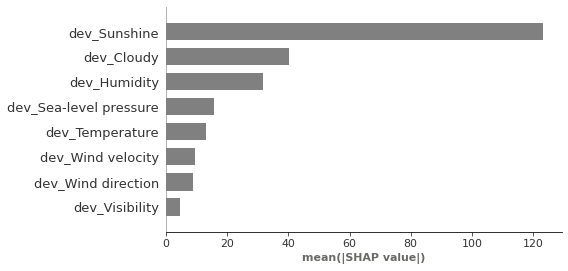

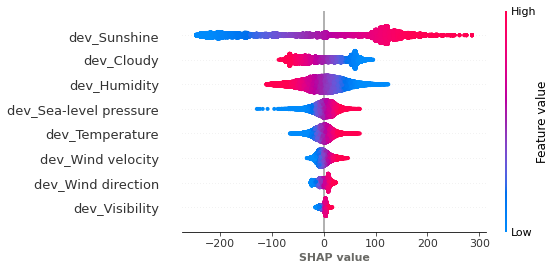

In [ ]:
ShapPlot(**Shap_dic['dev_LR'])

In [22]:
LR = MLTest(df, 'LR', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

LinearRegression()


## MLP 
- Multi-Layer Perceptron regressor

In [ ]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

train: (5382, 8), (5382, 1) valid: (5381, 8), (5381, 1)

train: (10763, 8), (10763, 1) valid: (5381, 8), (5381, 1)

train: (16144, 8), (16144, 1) valid: (5381, 8), (5381, 1)

train: (21525, 8), (21525, 1) valid: (5381, 8), (5381, 1)

train: (26906, 8), (26906, 1) valid: (5381, 8), (5381, 1)

MLPRegressor(activation='logistic', learning_rate='adaptive', max_iter=4000)


Exact explainer: 32288it [1:07:37,  7.93it/s]


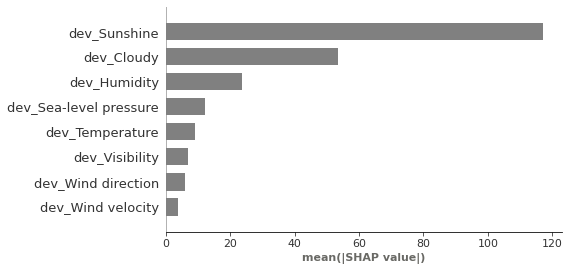

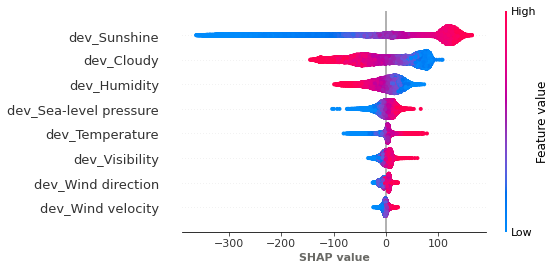

In [ ]:
ShapPlot(**Shap_dic['dev_MLP'])

In [23]:
MLP = MLTest(df, 'MLP', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(400,), max_iter=3000)


## LGBM
 - Light Gradient Boosting Model regressor

In [ ]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)

train: (5382, 8), (5382, 1) valid: (5381, 8), (5381, 1)

train: (10763, 8), (10763, 1) valid: (5381, 8), (5381, 1)

train: (16144, 8), (16144, 1) valid: (5381, 8), (5381, 1)

train: (21525, 8), (21525, 1) valid: (5381, 8), (5381, 1)

train: (26906, 8), (26906, 1) valid: (5381, 8), (5381, 1)



Exact explainer: 32288it [1:22:25,  6.51it/s]


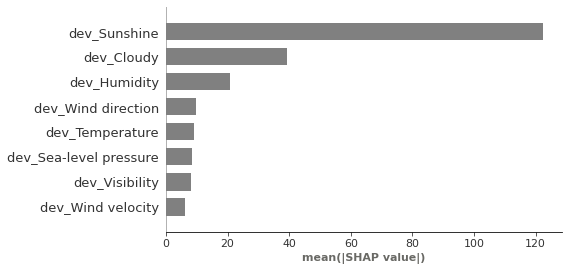

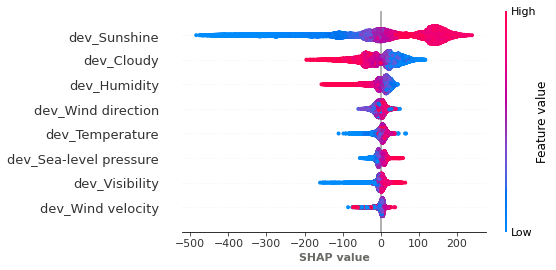

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

In [24]:
LGBM = MLTest(df, 'LGBM', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)



## RNN Models
(Recurrent Neural Network)

- LSTM (Long Short-Term Memory)

In [ ]:
pred_LSTM = Model_RNN(df, 'LSTM', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32267, 20, 8), (32267, 1) test: (4303, 20, 8), (4303, 1)


train_set : (5382, 20, 8), valid_set : (5377, 20, 8)



train_set : (10759, 20, 8), valid_set : (5377, 20, 8)

train_set : (16136, 20, 8), valid_set : (5377, 20, 8)

train_set : (21513, 20, 8), valid_set : (5377, 20, 8)

train_set : (26890, 20, 8), valid_set : (5377, 20, 8)


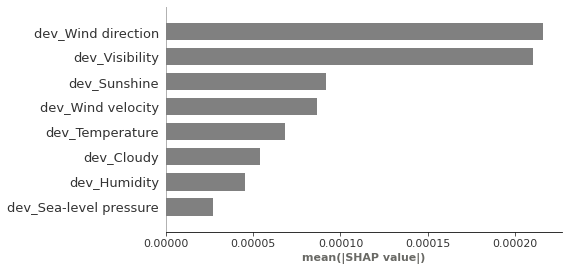

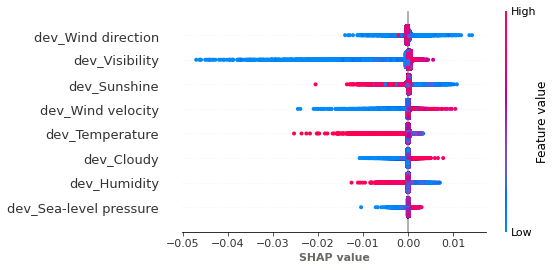

In [ ]:
Shap_RNN(**Shap_dic['dev_LSTM'])

In [25]:
LSTM = Model_RNN(df, 'LSTM', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32267, 20, 8), (32267, 1) test: (4303, 20, 8), (4303, 1)


train_set : (5382, 20, 8), valid_set : (5377, 20, 8)



train_set : (10759, 20, 8), valid_set : (5377, 20, 8)

train_set : (16136, 20, 8), valid_set : (5377, 20, 8)

train_set : (21513, 20, 8), valid_set : (5377, 20, 8)

train_set : (26890, 20, 8), valid_set : (5377, 20, 8)


- GRU (Gated Recurrent Unit)

In [ ]:
pred_GRU = Model_RNN(df, 'GRU', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32267, 20, 8), (32267, 1) test: (4303, 20, 8), (4303, 1)


train_set : (5382, 20, 8), valid_set : (5377, 20, 8)

train_set : (10759, 20, 8), valid_set : (5377, 20, 8)

train_set : (16136, 20, 8), valid_set : (5377, 20, 8)

train_set : (21513, 20, 8), valid_set : (5377, 20, 8)

train_set : (26890, 20, 8), valid_set : (5377, 20, 8)


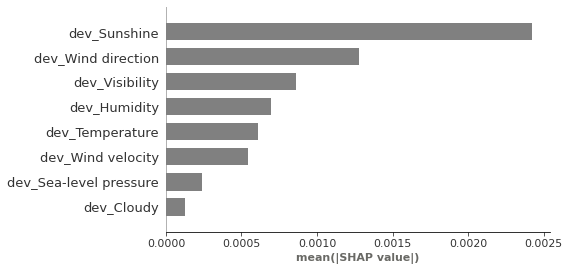

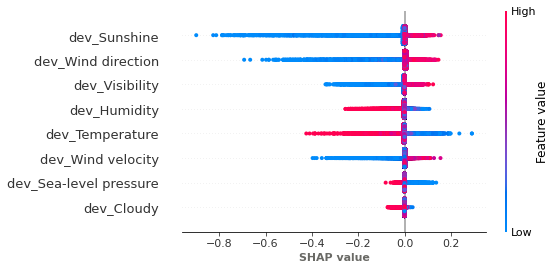

In [ ]:
Shap_RNN(**Shap_dic['dev_GRU'])

In [26]:
GRU = Model_RNN(df, 'GRU', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (32267, 20, 8), (32267, 1) test: (4303, 20, 8), (4303, 1)


train_set : (5382, 20, 8), valid_set : (5377, 20, 8)

train_set : (10759, 20, 8), valid_set : (5377, 20, 8)

train_set : (16136, 20, 8), valid_set : (5377, 20, 8)

train_set : (21513, 20, 8), valid_set : (5377, 20, 8)

train_set : (26890, 20, 8), valid_set : (5377, 20, 8)


# Score

In [ ]:
score 

{'EVS_dev_LR': 0.8175079977289291,
 'MAPE_dev_LR': 8.187379775369115,
 'EVS_dev_MLP': 0.8347967817875019,
 'MAPE_dev_MLP': 5.75196774446764,
 'EVS_dev_LGBM': 0.8349489003733397,
 'MAPE_dev_LGBM': 4.1150458421698906,
 'EVS_dev_LSTM': 0.5710450137024365,
 'MAPE_dev_LSTM': 2.8072666777229265,
 'EVS_dev_GRU': 0.5710008387208325,
 'MAPE_dev_GRU': 2.8099948733077755}

In [27]:
ori_score

{'EVS_LR': 0.5569625073225013,
 'MAPE_LR': 13.747340302536331,
 'EVS_MLP': 0.5771966448666215,
 'MAPE_MLP': 15.184980246500638,
 'EVS_LGBM': 0.6201215889391007,
 'MAPE_LGBM': 11.9114784675802,
 'EVS_LSTM': 0.007108648582292099,
 'MAPE_LSTM': 1.0018192086219126,
 'EVS_GRU': 0.0,
 'MAPE_GRU': 0.9833957513172386}

# SHAP of best model
- 가장 성능이 좋은 모델의 shap과 상위 요소들간의 관계

In [ ]:
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  plt.title('(a) Mokpo', loc='left', pad=15, fontsize=20)
  shap.summary_plot(shap_values, x_train, plot_size=0.4, plot_type='bar', show=False, color='grey')
  plt.xlabel('mean(|SHAP value|)', fontsize=13, color='#696965', fontweight='semibold')
  plt.savefig('shap1_Mokpo.png', bbox_inches='tight', dpi=500)
  plt.show()

  plt.title('(c) Mokpo', loc='left', pad=15, fontsize=20)
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.xlabel('SHAP value', fontsize=13, color='#696965', fontweight='semibold')
  plt.savefig('shap2_Mokpo.png', bbox_inches='tight', dpi=500)
  plt.show()

Exact explainer: 32288it [1:23:10,  6.47it/s]


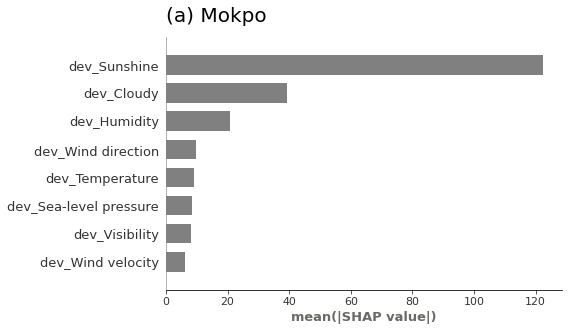

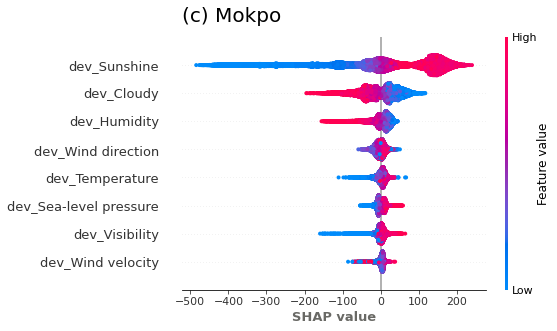

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

In [ ]:
def Shap_feature(model, x_train, model_name, col1, col2):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)
  shap.plots.scatter(shap_values[:,col1], color=shap_values[:,col2], show=False) 
  plt.title('(a) Mokpo', loc='left', pad=15, fontsize=20)
  plt.savefig('shap_variable_Mokpo.png', bbox_inches='tight', dpi=500)
  plt.show()

Exact explainer: 32288it [1:23:24,  6.44it/s]


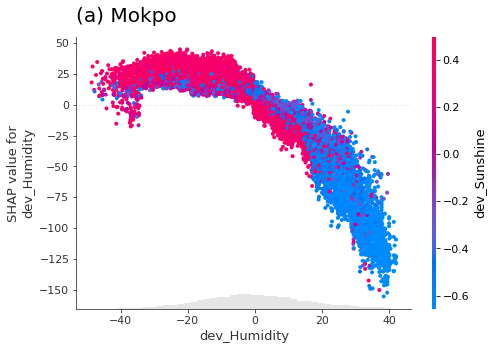

In [ ]:
Shap_feature(**Shap_dic['dev_LGBM'], col1='dev_Humidity', col2='dev_Sunshine') 

# Result save

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'RNN', dev = True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32267, 20, 8), (32267, 1) test: (4303, 20, 8), (4303, 1)



In [ ]:
df_lstm = pd.DataFrame(pred_LSTM)
df_gru = pd.DataFrame(pred_GRU)
pred_rnn = pd.concat([df_lstm, df_gru], axis=1)

In [ ]:
pred_cols = ['PV', 'LSTM_Pred', 'GRU_Pred', 'train_mean']
df_RNN = Result_RNN(df, y_test, pred_rnn, testmn, pred_cols)
df_RNN

,Area,Date,Month,Time,PV,LSTM_Pred,GRU_Pred,train_mean
0,전남 목포시,2021-01-03,1,8,0.12,0.806464,0.805274,0.809109
1,전남 목포시,2021-01-03,1,9,59.76,45.384216,45.383015,45.386849
2,전남 목포시,2021-01-03,1,10,388.92,245.204151,245.202954,245.206789
3,전남 목포시,2021-01-03,1,11,763.92,510.448439,510.447256,510.451091
4,전남 목포시,2021-01-03,1,12,1042.08,729.812467,729.811280,729.815115
...,...,...,...,...,...,...,...,...
4298,전남 목포시,2021-12-31,12,14,312.00,670.155642,670.154426,670.158261
4299,전남 목포시,2021-12-31,12,15,163.80,434.276216,434.275000,434.278835
4300,전남 목포시,2021-12-31,12,16,103.44,266.358501,266.357308,266.361143
4301,전남 목포시,2021-12-31,12,17,45.36,56.842658,56.841473,56.845308


In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (32287, 8), (32287, 1) test: (4323, 8), (4323, 1)



In [ ]:
df_ML = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)
df_ML.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)
df_ML

,Area,Date,Month,Time,PV,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,전남 목포시,2021-01-01,1,9,25.20,18.642216,67.186924,49.694967,45.386849
1,전남 목포시,2021-01-01,1,10,323.28,262.144405,294.337609,254.601915,245.206789
2,전남 목포시,2021-01-01,1,11,564.00,421.240473,450.426121,474.570407,510.451091
3,전남 목포시,2021-01-01,1,12,442.44,563.037279,615.423312,617.126446,729.815115
4,전남 목포시,2021-01-01,1,13,563.88,683.986024,724.856472,720.466533,810.791111
...,...,...,...,...,...,...,...,...,...
4318,전남 목포시,2021-12-31,12,14,312.00,439.637506,471.306525,552.836567,670.158261
4319,전남 목포시,2021-12-31,12,15,163.80,57.036833,-125.406999,-64.486557,434.278835
4320,전남 목포시,2021-12-31,12,16,103.44,-77.092740,-210.456974,-64.198885,266.361143
4321,전남 목포시,2021-12-31,12,17,45.36,-162.292755,-172.223679,-181.680958,56.845308


In [ ]:
df_ML.to_csv('/content/gdrive/MyDrive/SolarPower/Mokpo_ML.csv')
df_RNN.to_csv('/content/gdrive/MyDrive/SolarPower/Mokpo_RNN.csv')